In [1]:
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import seaborn as sns
from qtools import Submitter
import glob
from tqdm import tnrange, tqdm_notebook


Goal of this notebook is to see which genes I can run the script on. The criteria is that they have to be genes that correspond to a PacBio isoform (based on the classification.txt file and they have to be a gene with count >0. It also has to be a gene with at least two isoforms. 

In [2]:
working_dir = '/home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/percent_edited_reads/'

In [3]:
data_dir = '/home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix'

In [5]:
gene_counts = pd.read_csv(os.path.join(working_dir, './rbfox2_pacBio_counts_tables/countDFeByg.xls'), sep = '\t', index_col = 0)

In [6]:
gene_counts.head()

,RBFOX_PacBio_181120_merged.sorted.bam
ENSG00000000003.10,177
ENSG00000000005.5,0
ENSG00000000419.8,4
ENSG00000000457.9,53
ENSG00000000460.12,111


In [7]:
gene_counts.shape

(57820, 1)

In [8]:
gene_counts = gene_counts[gene_counts['RBFOX_PacBio_181120_merged.sorted.bam']>0]

In [9]:
gene_counts.shape

(14133, 1)

In [10]:
hg19_gencode_gtf = pd.read_csv('/home/pjaganna1/genomes/hg19/gencode.v19.annotation.gtf', sep='\t', skiprows=5, header=None)

In [11]:
def get_geneName_from_gtf(row):
    '''populating dictionary with ensemble ID key and gene name value from the provided GTF'''
    ensembl_to_geneName[row[8].split(';')[0].split('\"')[1]] = row[8].split(';')[4].split('\"')[1]
    gene_strand_chrom[row[8].split(';')[4].split('\"')[1]] = [row[6],
                                                              row[0]]  # storing gene and strand info for each gene

In [12]:
ensembl_to_geneName = {}
gene_strand_chrom = {}
hg19_gencode_gtf[hg19_gencode_gtf[2] == 'gene'].apply(get_geneName_from_gtf, axis=1)  # only processing 'gene' rows

0          None
21         None
82         None
92         None
100        None
           ... 
2619425    None
2619430    None
2619433    None
2619438    None
2619441    None
Length: 57820, dtype: object

In [13]:
gene_counts['gene_name'] = gene_counts.index.map(ensembl_to_geneName)

In [14]:
gene_counts.shape

(14133, 2)

In [15]:
gene_counts.head(10)

,RBFOX_PacBio_181120_merged.sorted.bam,gene_name
ENSG00000000003.10,177,TSPAN6
ENSG00000000419.8,4,DPM1
ENSG00000000457.9,53,SCYL3
ENSG00000000460.12,111,C1orf112
ENSG00000001036.9,193,FUCA2
ENSG00000001084.6,41,GCLC
ENSG00000001167.10,19,NFYA
ENSG00000001460.13,30,STPG1
ENSG00000001461.12,77,NIPAL3
ENSG00000001497.12,243,LAS1L


In [16]:
gene_counts[gene_counts['gene_name']=='ZNF521']

,RBFOX_PacBio_181120_merged.sorted.bam,gene_name
ENSG00000198795.6,15,ZNF521


In [17]:
classification_info = pd.read_csv(os.path.join(working_dir, '../rbfox_isoform.collapsed_classification.txt'), sep='\t')
classification_info_subset = classification_info[['isoform', 'chrom', 'associated_gene']]
classification_info_subset['gene_name'] = classification_info_subset['associated_gene'].map(
        ensembl_to_geneName).fillna(classification_info_subset['associated_gene'])

/home/pjaganna1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [18]:
gene_list = []
for i in set(classification_info_subset['gene_name'].tolist()):
    if str(i) != 'nan':
        if ('novelGene' not in i) and ('ENSG' not in i):
            gene_list.append(i)

In [19]:
len(gene_list)

14674

In [20]:
common_genes = set(gene_list).intersection(set(gene_counts['gene_name'].tolist()))

In [21]:
classification_info_subset.head()

,isoform,chrom,associated_gene,gene_name
0,PB.1.1,chr1,ENSG00000227232.4,WASH7P
1,PB.1.10,chr1,ENSG00000227232.4,WASH7P
2,PB.1.11,chr1,ENSG00000227232.4,WASH7P
3,PB.1.12,chr1,ENSG00000227232.4,WASH7P
4,PB.1.13,chr1,ENSG00000227232.4,WASH7P


In [22]:
###This step takes a while 
final_gene_list = []
for gene in common_genes:
    if len(classification_info_subset[classification_info_subset['gene_name']==gene]['isoform'].tolist()) >=2:
        final_gene_list.append(gene)

In [23]:
len(final_gene_list)

11602

In [24]:
final_gene_list

['ATAD5',
 'AREL1',
 'NFIX',
 'LINC00883',
 'NTHL1',
 'SLC35F5',
 'WBP5',
 'SMIM13',
 'BAIAP2L1',
 'LRCH4',
 'RBPJ',
 'C11orf54',
 'ZNF562',
 'TIGD6',
 'PPAP2A',
 'TMOD3',
 'A1BG-AS1',
 'KLHL7-AS1',
 'FOXE1',
 'EIF4EBP2',
 'RTN4IP1',
 'B3GAT3',
 'F8',
 'PLOD3',
 'ZNF77',
 'TANC1',
 'DEF8',
 'GART',
 'RP11-631N16.2',
 'PIK3C3',
 'WWC1',
 'TOMM34',
 'SAMM50',
 'SRD5A3',
 'FLNA',
 'ZNF252P',
 'C10orf12',
 'PEMT',
 'PPIG',
 'C8orf76',
 'MRPL13',
 'STON2',
 'RAB2B',
 'COPS8',
 'ATF7IP',
 'TRAPPC12',
 'GTF2H2C',
 'GAREML',
 'RNF31',
 'SOX9',
 'NAT10',
 'WFS1',
 'HMGCS1',
 'SLC19A2',
 'UTS2R',
 'RIC8A',
 'DSTYK',
 'SHOX2',
 'FOXF2',
 'ZNF821',
 'AC034193.5',
 'ZNF83',
 'VPS4B',
 'RIPK4',
 'MID1IP1',
 'RP11-206L10.9',
 'RAB4A',
 'TROAP',
 'NDUFS4',
 'NARF',
 'HSD17B6',
 'RP11-195C7.1',
 'ZNF207',
 'RPS6KC1',
 'LL0XNC01-237H1.2',
 'HIST1H2BN',
 'TMEM9',
 'TXLNA',
 'CCDC15',
 'SNAPC3',
 'RPL21P75',
 'ZBTB11',
 'STARD5',
 'ZNF394',
 'ZNF391',
 'GLOD4',
 'MXD3',
 'CHPT1',
 'RPL28',
 'SRSF5',
 'UBE

In [25]:
############Don't run this again###################################################
###################################################################################
#def make_chunks(list_to_chunk, size):
chunk1 = len(final_gene_list)//20
chunk2 = chunk1//5

count = 1
for g in range(0, len(final_gene_list), chunk1):
    if g+chunk1 > len(final_gene_list)==True:
        list_chunk = final_gene_list[g:]
    else:
        list_chunk = final_gene_list[g:g+chunk1]
    cmds = []
    for y in range(0, len(list_chunk), 5):
        if y+5 > len(list_chunk) == True:
            sub_list_chunk = list_chunk[y:]
        else:
            sub_list_chunk = list_chunk[y:y+5]
        
        cmd = ['module load python3essential']
        for each in sub_list_chunk:
            cmd.append('python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ ' + each)
        cmds.append(';'.join(cmd))
    ##Submitter(cmds, 'pacbio_quant_chunk_' + str(count) , nodes=1, ppn=2, walltime='48:00:00', array=True, submit=False)
    count += 1
    print('\n'.join(cmds))
    print('\n')
    print('\n')

Writing 116 tasks as an array-job.
Wrote commands to pacbio_quant_chunk_1.sh.
Writing 116 tasks as an array-job.
Wrote commands to pacbio_quant_chunk_2.sh.
Writing 116 tasks as an array-job.


module load python3essential;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ ATAD5;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ AREL1;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ NFIX;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ LINC00883;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_scri

Wrote commands to pacbio_quant_chunk_3.sh.
Writing 116 tasks as an array-job.
Wrote commands to pacbio_quant_chunk_4.sh.
Writing 116 tasks as an array-job.
Wrote commands to pacbio_quant_chunk_5.sh.
Writing 116 tasks as an array-job.
Wrote commands to pacbio_quant_chunk_6.sh.
Writing 116 tasks as an array-job.
Wrote commands to pacbio_quant_chunk_7.sh.
Writing 116 tasks as an array-job.
Wrote commands to pacbio_quant_chunk_8.sh.
Writing 116 tasks as an array-job.


module load python3essential;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ EPHA7;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ TIGD2;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ SEC22B;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ MTFR1;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script

Wrote commands to pacbio_quant_chunk_9.sh.
Writing 116 tasks as an array-job.
Wrote commands to pacbio_quant_chunk_10.sh.
Writing 116 tasks as an array-job.
Wrote commands to pacbio_quant_chunk_11.sh.


module load python3essential;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ PIK3R4;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ HP1BP3;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ APEX1;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ MKNK1;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_scrip

Writing 116 tasks as an array-job.
Wrote commands to pacbio_quant_chunk_12.sh.
Writing 116 tasks as an array-job.
Wrote commands to pacbio_quant_chunk_13.sh.
Writing 116 tasks as an array-job.


module load python3essential;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ OARD1;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ YBEY;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ FNIP1;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ MRFAP1L1;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_scrip

Wrote commands to pacbio_quant_chunk_14.sh.
Writing 116 tasks as an array-job.
Wrote commands to pacbio_quant_chunk_15.sh.
Writing 116 tasks as an array-job.
Wrote commands to pacbio_quant_chunk_16.sh.
Writing 116 tasks as an array-job.
Wrote commands to pacbio_quant_chunk_17.sh.
Writing 116 tasks as an array-job.
Wrote commands to pacbio_quant_chunk_18.sh.
Writing 116 tasks as an array-job.
Wrote commands to pacbio_quant_chunk_19.sh.
Writing 116 tasks as an array-job.


module load python3essential;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ PPP1R12C;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ KCNB2;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ BHLHE41;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_script/genome-wide-pac-RBFOX2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/test/ OSBP2;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RBFOX2_bugfix/submitter_sc

Wrote commands to pacbio_quant_chunk_20.sh.
Writing 1 tasks as an array-job.
Wrote commands to pacbio_quant_chunk_21.sh.


In [26]:
chunk1 = len(final_gene_list)//20
gene_chunks = {}
count = 1
for g in range(0, len(final_gene_list), chunk1):
    if g+chunk1 > len(final_gene_list)==True:
        list_chunk = final_gene_list[g:]
    else:
        list_chunk = final_gene_list[g:g+chunk1]
    chunk_name = 'chunk_' + str(count)
    gene_chunks[chunk_name] = list_chunk
    count +=1

In [27]:
gene_chunks

{'chunk_1': ['ATAD5',
  'AREL1',
  'NFIX',
  'LINC00883',
  'NTHL1',
  'SLC35F5',
  'WBP5',
  'SMIM13',
  'BAIAP2L1',
  'LRCH4',
  'RBPJ',
  'C11orf54',
  'ZNF562',
  'TIGD6',
  'PPAP2A',
  'TMOD3',
  'A1BG-AS1',
  'KLHL7-AS1',
  'FOXE1',
  'EIF4EBP2',
  'RTN4IP1',
  'B3GAT3',
  'F8',
  'PLOD3',
  'ZNF77',
  'TANC1',
  'DEF8',
  'GART',
  'RP11-631N16.2',
  'PIK3C3',
  'WWC1',
  'TOMM34',
  'SAMM50',
  'SRD5A3',
  'FLNA',
  'ZNF252P',
  'C10orf12',
  'PEMT',
  'PPIG',
  'C8orf76',
  'MRPL13',
  'STON2',
  'RAB2B',
  'COPS8',
  'ATF7IP',
  'TRAPPC12',
  'GTF2H2C',
  'GAREML',
  'RNF31',
  'SOX9',
  'NAT10',
  'WFS1',
  'HMGCS1',
  'SLC19A2',
  'UTS2R',
  'RIC8A',
  'DSTYK',
  'SHOX2',
  'FOXF2',
  'ZNF821',
  'AC034193.5',
  'ZNF83',
  'VPS4B',
  'RIPK4',
  'MID1IP1',
  'RP11-206L10.9',
  'RAB4A',
  'TROAP',
  'NDUFS4',
  'NARF',
  'HSD17B6',
  'RP11-195C7.1',
  'ZNF207',
  'RPS6KC1',
  'LL0XNC01-237H1.2',
  'HIST1H2BN',
  'TMEM9',
  'TXLNA',
  'CCDC15',
  'SNAPC3',
  'RPL21P75',
  'ZBT

Checking that all files for all genes have something in them.

In [28]:
for gene in tqdm(final_gene_list):
    if os.path.exists(data_dir + '/' + gene + '_quantification_output.txt') ==True:
        if os.path.getsize(data_dir + '/' + gene + '_quantification_output.txt') == 0:
            print('File for {} is empty'.format(gene))
    else:
        print('File for {} doesn not exist'.format(gene))

 12%|█▏        | 1363/11602 [02:17<11:48, 14.44it/s] 

File for ZNF668 doesn not exist


 15%|█▍        | 1688/11602 [02:45<11:44, 14.08it/s]

File for DHRS4-AS1 doesn not exist


 23%|██▎       | 2658/11602 [04:05<16:38,  8.96it/s]

File for VAMP7 doesn not exist


 32%|███▏      | 3728/11602 [05:43<11:16, 11.64it/s]

File for RBL1 doesn not exist


 62%|██████▏   | 7190/11602 [11:23<07:01, 10.47it/s]

File for CKS1B doesn not exist


 65%|██████▌   | 7595/11602 [11:54<03:55, 17.04it/s]

File for SNORA76 doesn not exist


 82%|████████▏ | 9521/11602 [14:29<02:57, 11.75it/s]

File for KBTBD4 doesn not exist


 90%|████████▉ | 10401/11602 [15:41<01:25, 14.00it/s]

File for MIR4519 doesn not exist


100%|██████████| 11602/11602 [17:30<00:00, 11.04it/s]


In [29]:
genome_wide_gene = []
genome_wide_isoA = []
genome_wide_isoB = []
genome_wide_bins = []
for c in gene_chunks:
    print('Processing {}'.format(c))
    for gene in tqdm(gene_chunks[c]):
        if os.path.exists(data_dir + '/' + gene + '_quantification_output.txt') ==True:
            df = pd.read_csv(os.path.join(data_dir, gene + '_quantification_output.txt'), sep = '\t')
            if len(df) >1:
                df = df.sort_values('num_reads', ascending = False).iloc[:2,:]
                if len(df.dropna()) > 1:
                    if df.iloc[0,5]>=10 and df.iloc[1,5]>=10:
                        if df.iloc[0]['num_reads']/df.iloc[1]['num_reads']<=5:
                            genome_wide_gene.append(gene)
                            bins = [str(b) for b in df['bin'].tolist()]
                            genome_wide_bins.append(','.join(bins))
                            genome_wide_isoA.append(df.iloc[0]['percent reads edited'])
                            genome_wide_isoB.append(df.iloc[1]['percent reads edited'])
        

  0%|          | 0/580 [00:00<?, ?it/s]

Processing chunk_1


  0%|          | 2/580 [00:00<00:39, 14.68it/s]

Processing chunk_2


  0%|          | 1/580 [00:00<01:42,  5.64it/s]

Processing chunk_3


  0%|          | 0/580 [00:00<?, ?it/s]

Processing chunk_4


  0%|          | 0/580 [00:00<?, ?it/s]

Processing chunk_5


  0%|          | 0/580 [00:00<?, ?it/s]

Processing chunk_6


  0%|          | 0/580 [00:00<?, ?it/s]

Processing chunk_7


  0%|          | 2/580 [00:00<00:42, 13.70it/s]

Processing chunk_8


  0%|          | 2/580 [00:00<00:46, 12.39it/s]

Processing chunk_9


  0%|          | 1/580 [00:00<01:48,  5.32it/s]

Processing chunk_10


  0%|          | 2/580 [00:00<00:30, 18.76it/s]

Processing chunk_11


  0%|          | 0/580 [00:00<?, ?it/s]

Processing chunk_12


  0%|          | 2/580 [00:00<00:36, 15.79it/s]

Processing chunk_13


  0%|          | 0/580 [00:00<?, ?it/s]

Processing chunk_14


  0%|          | 0/580 [00:00<?, ?it/s]

Processing chunk_15


  0%|          | 0/580 [00:00<?, ?it/s]

Processing chunk_16


  0%|          | 0/580 [00:00<?, ?it/s]

Processing chunk_17


  0%|          | 1/580 [00:00<00:58,  9.86it/s]

Processing chunk_18


  0%|          | 0/580 [00:00<?, ?it/s]

Processing chunk_19


  0%|          | 0/580 [00:00<?, ?it/s]

Processing chunk_20


  0%|          | 0/2 [00:00<?, ?it/s]

Processing chunk_21


100%|██████████| 2/2 [00:00<00:00,  7.37it/s]


In [30]:
table=pd.DataFrame({'Gene':genome_wide_gene, 'bins':genome_wide_bins, 'IsoA': genome_wide_isoA, 'IsoB': genome_wide_isoB})

In [31]:
table = table.set_index('Gene')

In [32]:
table.shape

(1604, 3)

In [33]:
table.head()

,bins,IsoA,IsoB
Gene,,,
BAIAP2L1,"2,0",0.045455,0.000000
TMOD3,"6,7",0.363636,0.230769
EIF4EBP2,"6,13",0.494118,0.358974
GART,"14,13",0.081272,0.288889
PPIG,"7,19",0.000000,0.000000


In [34]:
#table.to_csv(os.path.join(working_dir, 'RBFOX2_genome_scale_pacbio_percent_edited_reads_bugfix.txt'), sep = '\t')

In [4]:
table = pd.read_csv(os.path.join(working_dir, 'RBFOX2_genome_scale_pacbio_percent_edited_reads_bugfix.txt'), sep = '\t', index_col=0)

In [5]:
table.head()

,bins,IsoA,IsoB
Gene,,,
BAIAP2L1,"2,0",0.045455,0.000000
TMOD3,"6,7",0.363636,0.230769
EIF4EBP2,"6,13",0.494118,0.358974
GART,"14,13",0.081272,0.288889
PPIG,"7,19",0.000000,0.000000


In [6]:
table['dif'] = table['IsoA']-table['IsoB']

In [7]:
table = table.sort_values('dif', ascending = False)

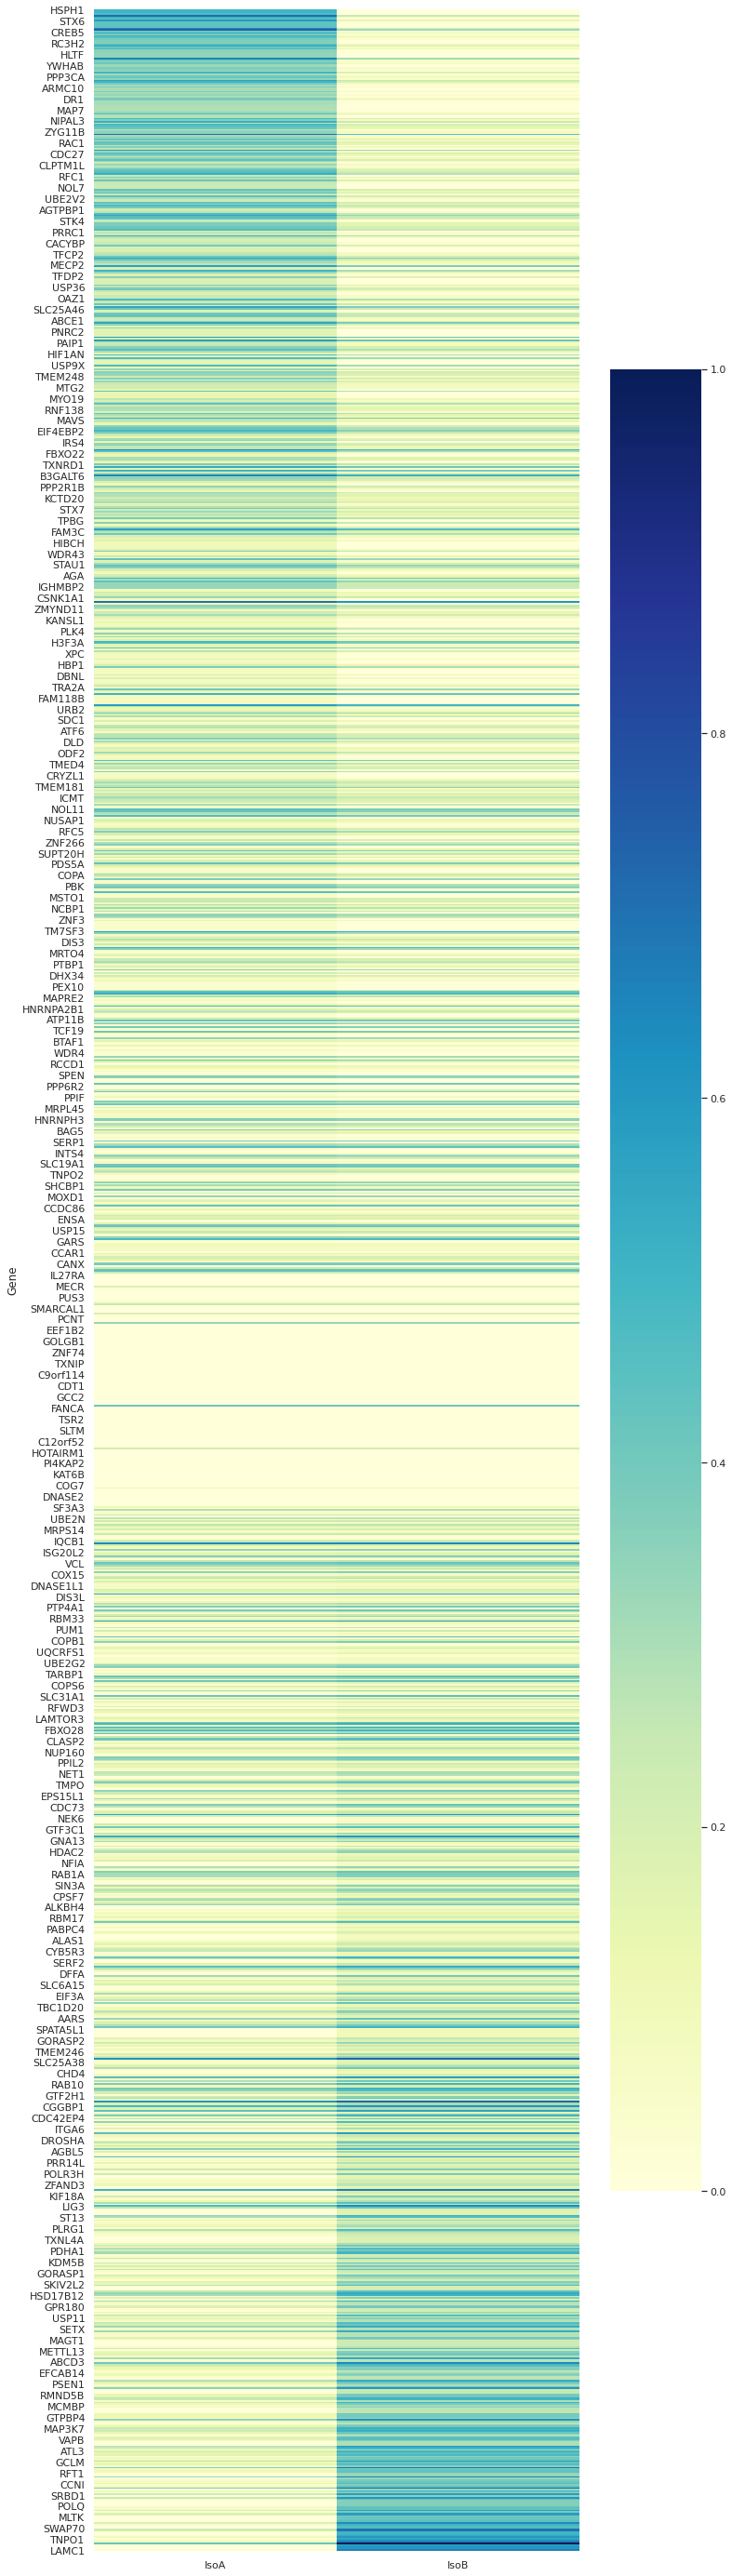

In [8]:
sns.set(rc={'figure.figsize':(11.7,50.27)})
ax = sns.heatmap(table[['IsoA', 'IsoB']],cmap="YlGnBu")
#plt.savefig(os.path.join(working_dir,'RBFOX2_heatmap.png'))
#plt.savefig(os.path.join(working_dir,'RBFOX2_heatmap.svg'))

In [42]:
table.tail()

,bins,IsoA,IsoB,dif
Gene,,,,
GPSM2,"3,4",0.421053,1.000000,-0.578947
GALNT1,"1,6",0.000000,0.583333,-0.583333
NUP155,"14,2",0.015873,0.615385,-0.599512
MTF2,"5,10",0.000000,0.600000,-0.600000
LAMC1,"10,13",0.032258,0.666667,-0.634409


In [106]:
table[table.index=='APP']

,bins,IsoA,IsoB,dif
Gene,,,,
APP,"1,4",0.511111,0.304348,0.206763


In [9]:
k_list = ['PIGN','MAP3K7','SYNCRIP', 'QKI', 'HNRNPK', 'TIA1', 'EIF4EBP2', 'HNRNPC', 'USP34', 'FMR1', 'SLC25A32', 'RPN1', 'PLAGL1', 'HNRNPA3', 'FAR1', 'U2SURP', 'CHTOP']

In [10]:
len(k_list)

17

In [11]:
' '.join(k_list)

'PIGN MAP3K7 SYNCRIP QKI HNRNPK TIA1 EIF4EBP2 HNRNPC USP34 FMR1 SLC25A32 RPN1 PLAGL1 HNRNPA3 FAR1 U2SURP CHTOP'

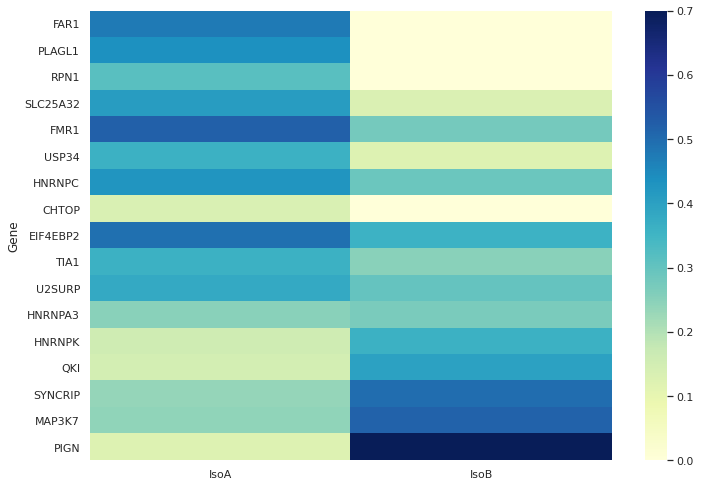

In [12]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(table[table.index.isin(k_list)].sort_values('dif', ascending = False)[['IsoA', 'IsoB']],cmap="YlGnBu")


In [13]:
table.loc['HSPH1','bins'].split(',')

['5', '17']

In [14]:
subset_gene = []
subset_isoA = []
subset_isoB = []
subset_bins = []
apo_data_path = '/home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RBFOX_isoform_edits/percent_edited_reads/Apo-control-edits-to-compare'
for c in tqdm(k_list):
    if os.path.exists(os.path.join(apo_data_path, c + '_Apo_quantification_output.txt')) ==True:
        df = pd.read_csv(os.path.join(apo_data_path, c + '_Apo_quantification_output.txt'), sep = '\t', index_col = 0)
        isoA, isoB = int(table.loc[c,'bins'].split(',')[0]), int(table.loc[c,'bins'].split(',')[1])
        subset_gene.append(c)
        subset_bins.append(','.join([str(isoA),str(isoB)]))
        subset_isoA.append(df.loc[isoA]['percent reads edited'])
        subset_isoB.append(df.loc[isoB]['percent reads edited'])

100%|██████████| 17/17 [00:00<00:00, 52.09it/s]


In [15]:
table_subset=pd.DataFrame({'Gene':subset_gene, 'bins':subset_bins, 'IsoA': subset_isoA, 'IsoB': subset_isoB})


In [16]:
table_subset = table_subset.set_index('Gene')

In [17]:
 fox_apo_merged_df = pd.concat([table[table.index.isin(k_list)].sort_values('dif', ascending = False)[['IsoA', 'IsoB']], table_subset[['IsoA','IsoB']]], join='inner', axis=1)

In [18]:
fox_apo_merged_df.columns = ['RBFOX2 A', 'RBFOX2 B', 'APOBEC A', 'APOBEC B']

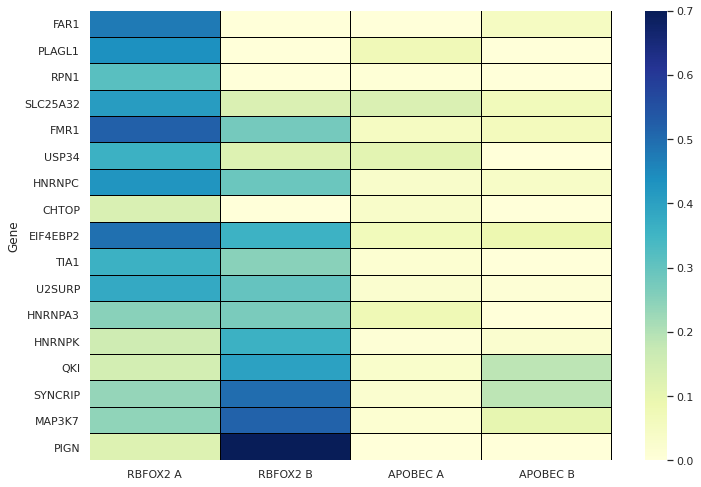

In [28]:
### made a version without the Grid which is just saved as RBFOX2_exampleSubset_heatmap_wGrid.*
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(fox_apo_merged_df,cmap="YlGnBu", linewidths=0.01,linecolor='black')
plt.savefig(os.path.join(working_dir,'RBFOX2_exampleSubset_heatmap_wGrid.png'))
plt.savefig(os.path.join(working_dir,'RBFOX2_exampleSubset_heatmap_wGrid.svg'))